In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure, transform
import cv2
import pydicom

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [4]:
classInfo = pd.read_csv('stage_2_detailed_class_info.csv')
trainlabels = pd.read_csv('stage_2_train_labels.csv')
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

In [5]:
num_unique_patients = classInfo['patientId'].nunique()

print(f"Number of unique patient IDs: {num_unique_patients}")

Number of unique patient IDs: 26684


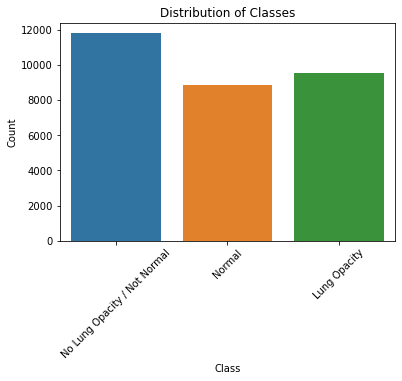

In [6]:
sns.countplot(x='class',data=classInfo);

# Displaying labels, title, and rotate the x-axis labels for better visualization
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [8]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(classInfo, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


In [9]:
classInfo[classInfo.duplicated()]

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity
...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,Lung Opacity
30215,c1cddf32-b957-4753-acaa-472ab1447e86,Lung Opacity
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity


In [10]:
# The expression classInfo.duplicated() returns a boolean mask with True for duplicate rows and False for non-duplicates.
# When this boolean mask is used to index the DataFrame, only the duplicate rows are selected.
duplicate_rows = classInfo[classInfo.duplicated()]

# Get the dimensions (number of rows and columns) of the DataFrame containing duplicate rows
# The 'shape' attribute of the DataFrame returns a tuple (num_rows, num_columns) representing its dimensions.
shape_of_duplicate_rows = duplicate_rows.shape
print(shape_of_duplicate_rows)

(3543, 2)


In [11]:
# Defining a function to check for missing values in each column of a DataFrame
def missing_check(df):
    # Calculate the total number of missing values in each column and sort in descending order
    total = df.isnull().sum().sort_values(ascending=False)

    # Calculate the percentage of missing values in each column and sort in descending order
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

    # Combine the 'total' and 'percent' Series into a new DataFrame named 'missing_data'
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    # Return the DataFrame containing information about missing values
    return missing_data

In [12]:
# Defining a function to check for missing values in each column of a DataFrame
def missing_check(df):
    # Calculate the total number of missing values in each column and sort in descending order
    total = df.isnull().sum().sort_values(ascending=False)

    # Calculate the percentage of missing values in each column and sort in descending order
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

    # Combine the 'total' and 'percent' Series into a new DataFrame named 'missing_data'
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    # Return the DataFrame containing information about missing values
    return missing_data

In [13]:
# Call the missing_check function to check for missing values in each column of the DataFrame classInfo
missing_data = missing_check(classInfo)


# Print the DataFrame containing information about missing values
print(missing_data)

           Total  Percent
patientId      0      0.0
class          0      0.0


In [14]:
# The `info()` method provides a concise summary of the DataFrame's structure.
# It displays essential information about the DataFrame, including the number of non-null values,
# data types of each column, and memory usage.
trainlabels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [15]:
# The `trainlabels.patientId` selects the 'patientId' column from the DataFrame.
# The `nunique()` method is then called on this column to get the number of unique patient IDs.
num_unique_patients = trainlabels.patientId.nunique()

In [16]:
# It selects rows from the DataFrame where the 'patientId' column has the value 'c1f7889a-9ea9-4acb-b64c-b737c929599a'.
selected_data = trainlabels[trainlabels.patientId == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

# Set the option to display all columns in a single line
pd.set_option('display.expand_frame_repr', False)

# Print the DataFrame containing the selected rows
print(selected_data)

                                  patientId      x      y  width  height  Target
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0       1
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0       1


In [17]:
# It selects rows from the DataFrame where all columns have duplicate values, indicating duplicate rows.
duplicated_rows = trainlabels[trainlabels.duplicated()]

# Print the DataFrame containing the duplicate rows
print(duplicated_rows)

Empty DataFrame
Columns: [patientId, x, y, width, height, Target]
Index: []


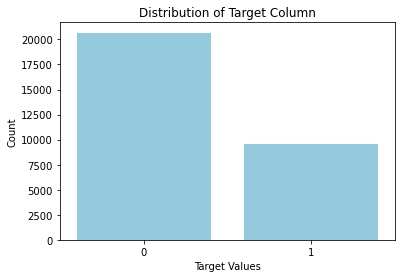

In [18]:
plt.figure()  # Create a new figure to ensure the previous plot doesn't overlap
sns.countplot(x='Target', data=trainlabels, color='skyblue',orient='h')
plt.title('Distribution of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display all the countplots
plt.show()

In [19]:
# Call the missing_check function to check for missing values in each column of the DataFrame 'trainlabels'
missing_data_trainlabels = missing_check(trainlabels)

# Print the DataFrame containing information about missing values
print(missing_data_trainlabels)

           Total   Percent
x          20672  0.683892
y          20672  0.683892
width      20672  0.683892
height     20672  0.683892
patientId      0  0.000000
Target         0  0.000000


In [20]:
# Select rows where the 'x' column has missing values (NaN)
missing_x_rows = trainlabels[trainlabels.x.isna()]

# Print the DataFrame containing rows with missing values in the 'x' column
print(missing_x_rows)

                                  patientId   x   y  width  height  Target
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
2      00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5 NaN NaN    NaN     NaN       0
6      00569f44-917d-4c86-a842-81832af98c30 NaN NaN    NaN     NaN       0
...                                     ...  ..  ..    ...     ...     ...
30216  c1cf3255-d734-4980-bfe0-967902ad7ed9 NaN NaN    NaN     NaN       0
30217  c1e228e4-b7b4-432b-a735-36c48fdb806f NaN NaN    NaN     NaN       0
30218  c1e3eb82-c55a-471f-a57f-fe1a823469da NaN NaN    NaN     NaN       0
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba NaN NaN    NaN     NaN       0
30224  c1f6b555-2eb1-4231-98f6-50a963976431 NaN NaN    NaN     NaN       0

[20672 rows x 6 columns]


In [21]:
# Select rows where the 'x' column has missing values (NaN)
# The expression 'trainlabels.x.isna()' returns a boolean mask with 'True' for rows where 'x' is NaN and 'False' otherwise.
# This boolean mask is then used as an index to select specific rows from the DataFrame 'trainlabels'.
# The result is a new DataFrame containing only the rows where the 'x' column has missing values.
missing_x_rows = trainlabels[trainlabels.x.isna()]

# Retrieve the unique values in the 'Target' column for the selected rows
# The 'Target' column of the DataFrame 'missing_x_rows' is accessed using ['Target'].
# The 'unique()' method is then called on this column to retrieve the unique values in the 'Target' column.
unique_target_values = missing_x_rows['Target'].unique()

# Print the unique values in the 'Target' column for the selected rows
print(unique_target_values)

[0]


In [22]:
# The code calls the 'describe()' method on the DataFrame 'trainlabels' to get summary statistics of the numerical columns.

# Display summary statistics of the DataFrame 'trainlabels'
# The 'describe()' method computes various summary statistics for each numerical column in the DataFrame.
# The statistics include count, mean, standard deviation, minimum value, 25th percentile (Q1), median (50th percentile or Q2),
# 75th percentile (Q3), and maximum value.
# The output will show these statistics for each numerical column in 'trainlabels'.
summary_stats = trainlabels.describe()

# Print the summary statistics of the DataFrame 'trainlabels'
print(summary_stats)

                 x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000


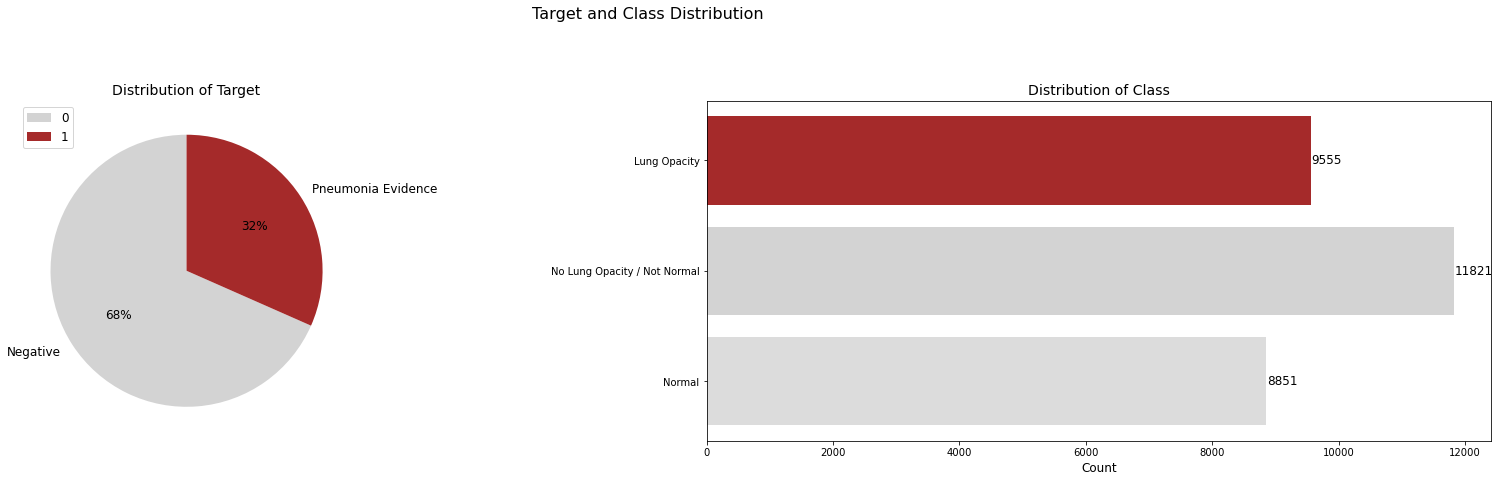

In [23]:
# Create a figure with two subplots and increase the figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))

# Plot the percentage distribution of 'Target' column using a pie chart
target_counts = trainlabels['Target'].value_counts()
ax1.pie(target_counts, labels=['Negative', 'Pneumonia Evidence'], colors=['lightgray', 'brown'],
        autopct='%.0f%%', startangle=90, textprops={'fontsize': 12})
ax1.set_title('Distribution of Target', fontsize=14)

# Plot the percentage distribution of 'class' column using a horizontal bar plot
class_counts = classInfo['class'].value_counts().sort_index(ascending=False)
ax2.barh(class_counts.index, class_counts, color=['gainsboro', 'lightgray', 'brown'])
ax2.set_xlabel('Count', fontsize=12)
ax2.set_title('Distribution of Class', fontsize=14)

# Add data labels to the bar plot
for i, v in enumerate(class_counts):
    ax2.text(v + 10, i, str(v), fontsize=12, color='black', va='center')

# Add a legend for the pie chart
ax1.legend(target_counts.index, loc='best', fontsize=12)

# Adjust the layout for subplots and add an overall title for the figure
plt.suptitle('Target and Class Distribution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])  # Adjust the 'rect' parameter to control the figure layout

# Show the plots
plt.show()

In [24]:
# Drop duplicate rows from the DataFrame 'classInfo'
classInfo.drop_duplicates(inplace=True)

# Print the DataFrame after dropping duplicates
print(classInfo)

                                  patientId                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
...                                     ...                           ...
30219  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2                  Lung Opacity
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

[26684 rows x 2 columns]


In [25]:
# The code performs an inner join (merge) between the 'trainlabels' and 'classInfo' DataFrames based on the 'patientId' column.

# Merge the DataFrames 'trainlabels' and 'classInfo' based on the common 'patientId' column.
# The 'left_on' parameter specifies the column in the left DataFrame (trainlabels) to use for the merge.
# The 'right_on' parameter specifies the column in the right DataFrame (classInfo) to use for the merge.
# The 'how' parameter is set to 'inner', which means only the rows with matching 'patientId' values in both DataFrames will be included in the result.

traindf = trainlabels.merge(classInfo, left_on='patientId', right_on='patientId', how='inner')

In [26]:
# The code filters the DataFrame 'traindf' to select rows where the 'patientId' column has the value 'c1f7889a-9ea9-4acb-b64c-b737c929599a'.

# Select rows from the DataFrame 'traindf' where the 'patientId' column is equal to 'c1f7889a-9ea9-4acb-b64c-b737c929599a'.
filtered_traindf = traindf[traindf.patientId == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

# Print the output to see the DataFrame with filtered rows
print(filtered_traindf)

                                  patientId      x      y  width  height  Target         class
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0       1  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0       1  Lung Opacity


In [27]:
# The code retrieves the unique values from the 'Target' column in the DataFrame 'traindf'.

# Get the unique values from the 'Target' column in the DataFrame 'traindf'.
unique_targets = traindf.Target.unique()

# Print the unique values to see the distinct target values in the 'traindf' DataFrame.
print(unique_targets)

[0 1]


In [28]:
# The code groups the DataFrame 'traindf' by the columns 'class' and 'Target', and then calculates the size of each group (i.e., the number of patients) within each combination of 'class' and 'Target'.

# Group the DataFrame 'traindf' by the columns 'class' and 'Target', and calculate the size of each group (number of patients).
grouped_traindf = traindf.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

# Print the output to see the DataFrame with the grouped results and patient counts.
print(grouped_traindf)

                          class  Target  Patient Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851


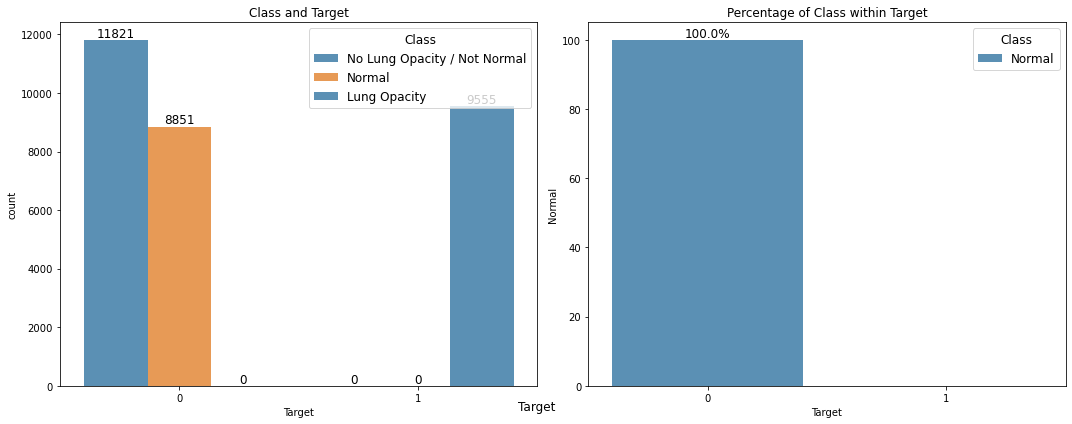

In [29]:
# The code groups the DataFrame 'traindf' by the 'Target' and 'class' columns, and calculates the count of each unique combination.
# It then creates a bar plot and a percentage bar chart to visualize the relationship between 'Target' and 'class' with improved visualizations.

# Create a figure with two subplots side by side and set the figure size to (15, 6).
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Group the DataFrame 'traindf' by 'Target' and 'class', and calculate the count of each unique combination.
tmp = traindf.groupby(['Target', 'class']).size().reset_index(name='count')

# Create a bar plot using Seaborn's 'sns.barplot'.
# 'x' represents the 'Target' column, 'y' represents the 'count' column (count of each class per Target),
# and 'hue' represents the 'class' column to distinguish the classes in the plot.
# 'palette' sets the color palette for the bars.
# 'alpha' adjusts the transparency of the bars to improve visibility.
sns.barplot(ax=ax1, x='Target', y='count', hue='class', data=tmp, palette=['#1f77b4', '#ff7f0e'], alpha=0.8)

# Add data labels to the bars to display the exact count values.
for p in ax1.patches:
    height = p.get_height()
    if pd.notnull(height):  # Check if height is not NaN before converting to integer
        ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=12)
    else:  # Handle NaN values and display "0" for zero counts
        ax1.annotate('0', (p.get_x() + p.get_width() / 2, 0), ha='center', va='bottom', fontsize=12)

# Set a title for the first plot.
ax1.set_title("Class and Target")

# Set the legend title and position for better readability in the first plot.
ax1.legend(title='Class', title_fontsize=12, fontsize=12, loc='upper right')

# Calculate the percentage of each class within each 'Target' group.
percentage_df = tmp.pivot_table(index='Target', columns='class', values='count', aggfunc=lambda x: x / x.sum() * 100).reset_index()

# Create a percentage bar chart using Seaborn's 'sns.barplot' for the second subplot.
sns.barplot(ax=ax2, x='Target', y='Normal', data=percentage_df, color='#1f77b4', label='Normal', alpha=0.8)

# Check if the 'Pneumonia' class is present in 'percentage_df'.
if 'Pneumonia' in percentage_df.columns:
    sns.barplot(ax=ax2, x='Target', y='Pneumonia', data=percentage_df, color='#ff7f0e', label='Pneumonia', alpha=0.8)
else:
    percentage_df['Pneumonia'] = 0

# Add data labels to the percentage bars to display the exact percentage values.
for p in ax2.patches:
    height = p.get_height()
    if pd.notnull(height):  # Check if height is not NaN before displaying data labels
        ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=12)

# Set a title for the second plot.
ax2.set_title("Percentage of Class within Target")

# Set the legend title and position for better readability in the second plot.
ax2.legend(title='Class', title_fontsize=12, fontsize=12, loc='upper right')

# Set common y-axis label for both subplots.
fig.text(0.5, 0.04, 'Target', ha='center', fontsize=12)

# Show the plots.
plt.tight_layout()
plt.show()

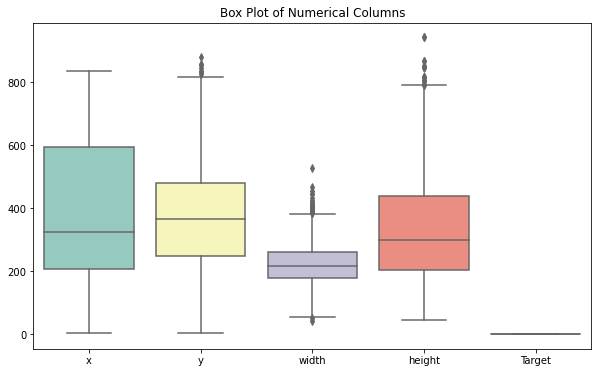

In [30]:
# Create a box plot to visualize the distribution of numerical columns in 'traindf'.

# Set the figure size to (10, 6) for better visibility.
plt.figure(figsize=(10, 6))

# Create the box plot using Seaborn.
sns.boxplot(data=traindf, palette='Set3')

# Add a title to the plot.
plt.title("Box Plot of Numerical Columns")

# Show the plot.
plt.show()

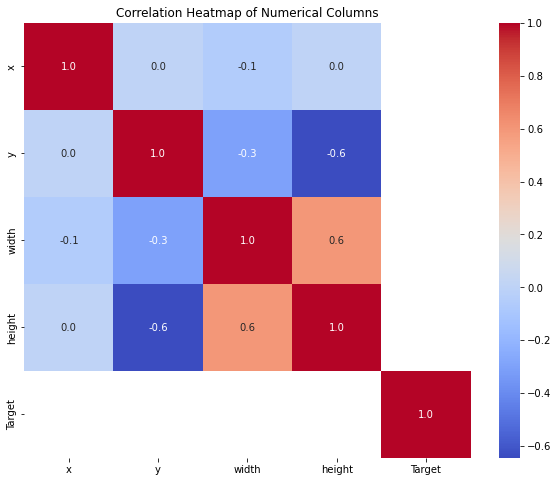

In [31]:
# The 'corr()' function computes the pairwise correlation of columns in a DataFrame. It returns a new DataFrame
# where each entry is the correlation coefficient between two columns. The correlation coefficient varies
# between -1 and 1. A positive value indicates a positive correlation (when one variable increases, the other tends
# to increase as well), while a negative value indicates a negative correlation (when one variable increases, the
# other tends to decrease).

# Let's compute the correlation matrix for the 'traindf' DataFrame:
correlation_matrix = traindf.corr()

# Create a heatmap to visualize the correlation matrix using Seaborn's 'sns.heatmap' function.

# Set the figure size to (10, 8) for better visibility.
plt.figure(figsize=(10, 8))

# Create the heatmap using Seaborn.
# 'annot' parameter displays the correlation coefficient values on the heatmap.
# 'fmt' parameter sets the format of the annotation to show correlation coefficients with one decimal point.
# 'cmap' parameter sets the color map for the heatmap.
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm")

# Add a title to the plot.
plt.title("Correlation Heatmap of Numerical Columns")

# Show the plot.
plt.show()

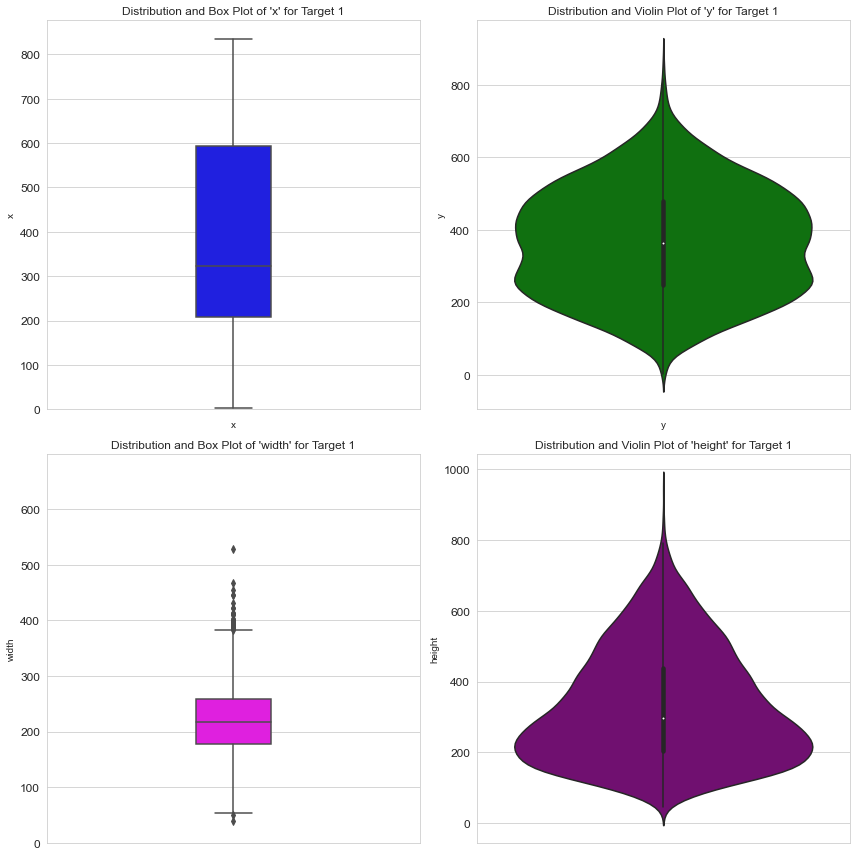

In [32]:
# In this code, we are visualizing the distribution of numerical columns for the rows where 'Target' equals 1.
# We create four subplots (2x2) to display the distribution of 'x', 'y', 'width', and 'height'.

# Let's create the 'target1' DataFrame containing rows where 'Target' is equal to 1.
target1 = traindf[traindf['Target'] == 1]

# Set the Seaborn style to 'whitegrid' for better visibility of grids on the plots.
sns.set_style('whitegrid')

# Create a figure and subplots with a size of (12, 12).
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Plot the distribution of 'x' with a KDE plot and a box plot on the first subplot.
sns.histplot(target1['x'], kde=True, bins=50, color="red", ax=ax[0, 0])
sns.boxplot(y=target1['x'], color="blue", width=0.2, ax=ax[0, 0])
ax[0, 0].set_title("Distribution and Box Plot of 'x' for Target 1", fontsize=12)

# Plot the distribution of 'y' with a KDE plot and a violin plot on the second subplot.
sns.histplot(target1['y'], kde=True, bins=50, color="blue", ax=ax[0, 1])
sns.violinplot(y=target1['y'], color="green", ax=ax[0, 1])
ax[0, 1].set_title("Distribution and Violin Plot of 'y' for Target 1", fontsize=12)

# Plot the distribution of 'width' with a KDE plot and a box plot on the third subplot.
sns.histplot(target1['width'], kde=True, bins=50, color="green", ax=ax[1, 0])
sns.boxplot(y=target1['width'], color="magenta", width=0.2, ax=ax[1, 0])
ax[1, 0].set_title("Distribution and Box Plot of 'width' for Target 1", fontsize=12)

# Plot the distribution of 'height' with a KDE plot and a violin plot on the fourth subplot.
sns.histplot(target1['height'], kde=True, bins=50, color="magenta", ax=ax[1, 1])
sns.violinplot(y=target1['height'], color="purple", ax=ax[1, 1])
ax[1, 1].set_title("Distribution and Violin Plot of 'height' for Target 1", fontsize=12)

# Remove x-axis labels from KDE plots to avoid clutter.
for i in range(2):
    ax[1, i].set_xlabel('')

# Adjust the tick label font size for better readability.
for ax_row in ax:
    for ax_col in ax_row:
        ax_col.tick_params(axis='both', which='major', labelsize=12)

# Adjust the layout to avoid overlapping titles and labels.
plt.tight_layout()

# Display the plot.
plt.show()

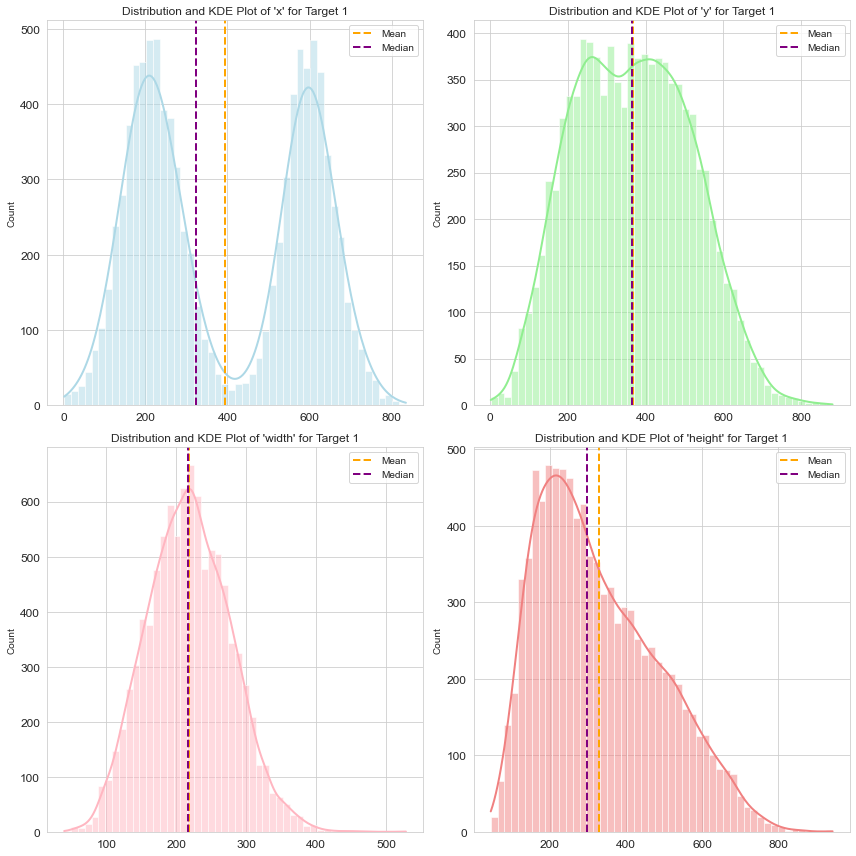

In [33]:
# In this code, we are visualizing the distribution of numerical columns for the rows where 'Target' equals 1.
# We create four subplots (2x2) to display the distribution of 'x', 'y', 'width', and 'height'.

# Let's create the 'target1' DataFrame containing rows where 'Target' is equal to 1.
target1 = traindf[traindf['Target'] == 1]

# Set the Seaborn style to 'whitegrid' for better visibility of grids on the plots.
sns.set_style('whitegrid')

# Create a figure and subplots with a size of (12, 12).
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Plot the distribution of 'x' with a histogram and a KDE plot on the first subplot.
sns.histplot(target1['x'], bins=50, color="lightblue", ax=ax[0, 0], kde=True, line_kws={'color': 'red', 'lw': 2})
mean_x = target1['x'].mean()
median_x = target1['x'].median()
ax[0, 0].axvline(mean_x, color='orange', linestyle='dashed', linewidth=2, label='Mean')
ax[0, 0].axvline(median_x, color='purple', linestyle='dashed', linewidth=2, label='Median')
ax[0, 0].legend()
ax[0, 0].set_title("Distribution and KDE Plot of 'x' for Target 1", fontsize=12)

# Plot the distribution of 'y' with a histogram and a KDE plot on the second subplot.
sns.histplot(target1['y'], bins=50, color="lightgreen", ax=ax[0, 1], kde=True, line_kws={'color': 'blue', 'lw': 2})
mean_y = target1['y'].mean()
median_y = target1['y'].median()
ax[0, 1].axvline(mean_y, color='orange', linestyle='dashed', linewidth=2, label='Mean')
ax[0, 1].axvline(median_y, color='purple', linestyle='dashed', linewidth=2, label='Median')
ax[0, 1].legend()
ax[0, 1].set_title("Distribution and KDE Plot of 'y' for Target 1", fontsize=12)

# Plot the distribution of 'width' with a histogram and a KDE plot on the third subplot.
sns.histplot(target1['width'], bins=50, color="lightpink", ax=ax[1, 0], kde=True, line_kws={'color': 'red', 'lw': 2})
mean_width = target1['width'].mean()
median_width = target1['width'].median()
ax[1, 0].axvline(mean_width, color='orange', linestyle='dashed', linewidth=2, label='Mean')
ax[1, 0].axvline(median_width, color='purple', linestyle='dashed', linewidth=2, label='Median')
ax[1, 0].legend()
ax[1, 0].set_title("Distribution and KDE Plot of 'width' for Target 1", fontsize=12)

# Plot the distribution of 'height' with a histogram and a KDE plot on the fourth subplot.
sns.histplot(target1['height'], bins=50, color="lightcoral", ax=ax[1, 1], kde=True, line_kws={'color': 'blue', 'lw': 2})
mean_height = target1['height'].mean()
median_height = target1['height'].median()
ax[1, 1].axvline(mean_height, color='orange', linestyle='dashed', linewidth=2, label='Mean')
ax[1, 1].axvline(median_height, color='purple', linestyle='dashed', linewidth=2, label='Median')
ax[1, 1].legend()
ax[1, 1].set_title("Distribution and KDE Plot of 'height' for Target 1", fontsize=12)

# Remove x-axis labels from all plots to avoid clutter.
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('')

# Adjust the tick label font size for better readability.
for ax_row in ax:
    for ax_col in ax_row:
        ax_col.tick_params(axis='both', which='major', labelsize=12)

# Adjust the layout to avoid overlapping titles and labels.
plt.tight_layout()

# Display the plot.
plt.show()

In [34]:
traindf.shape

(30227, 7)

In [35]:
final_train_data = traindf.copy()

In [36]:
print('Number of Training Images',len(os.listdir(trainImagesPath)))
print('Number of Test Images',len(os.listdir(testImagesPath)))

Number of Training Images 26684
Number of Test Images 3000


In [37]:
final_train_data.shape

(30227, 7)

In [38]:
path = 'stage_2_train_images/*.dcm'
final_train_data['image_path'] = ''

for i in range(len(final_train_data)):
    patient_id = final_train_data['patientId'][i]
    image_path = os.path.join('stage_2_train_images', patient_id + '.dcm')
    final_train_data['image_path'][i] = image_path

C:\Users\anant\AppData\Local\Temp\ipykernel_16276\2876126480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_data['image_path'][i] = image_path


In [40]:
final_train_data

,patientId,x,y,width,height,Target,class,image_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images\0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images\00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images\00436515-870c-4b36-a041-d...
...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,stage_2_train_images\c1ec14ff-f6d7-4b38-b0cb-f...
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images\c1edf42b-5958-47ff-a1e7-4...
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images\c1f6b555-2eb1-4231-98f6-5...
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,stage_2_train_images\c1f7889a-9ea9-4acb-b64c-b...


In [41]:
! pip install pydicom

In [42]:
import pydicom

In [43]:
for i in range(2):
    image_path = final_train_data['image_path'][i]
    meta_data = pydicom.read_file(image_path)
    print(meta_data)
    print('--------------------------------------------------------------------------------------------------------------------')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [44]:
patient_age = []
patient_sex = []
modality = []
view_position = []
lossy_image_compression = []

for index, row in final_train_data.iterrows():
    image_path = row['image_path']
    dcm = pydicom.dcmread(image_path)
    
    # Extract Patient's Age
    patient_age.append(dcm.PatientAge)
    
    # Extract Patient's Sex
    patient_sex.append(dcm.PatientSex)
    
    # Extract Modality
    modality.append(dcm.Modality)
    
    # Extract View Position
    view_position.append(dcm.ViewPosition)
    
    # Extract Lossy Image Compression
    lossy_image_compression.append(dcm.LossyImageCompression)

final_train_data['PatientAge'] = patient_age
final_train_data['PatientSex'] = patient_sex
final_train_data['Modality'] = modality
final_train_data['ViewPosition'] = view_position
final_train_data['LossyImageCompression'] = lossy_image_compression

In [45]:
final_train_data.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class',
       'image_path', 'PatientAge', 'PatientSex', 'Modality', 'ViewPosition',
       'LossyImageCompression'],
      dtype='object')

In [46]:
final_train_data

,patientId,x,y,width,height,Target,class,image_path,PatientAge,PatientSex,Modality,ViewPosition,LossyImageCompression
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images\0004cfab-14fd-4e49-80ba-6...,51,F,CR,PA,01
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...,48,F,CR,PA,01
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images\00322d4d-1c29-4943-afc9-b...,19,M,CR,AP,01
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...,28,M,CR,PA,01
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images\00436515-870c-4b36-a041-d...,32,F,CR,AP,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,stage_2_train_images\c1ec14ff-f6d7-4b38-b0cb-f...,54,M,CR,AP,01
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images\c1edf42b-5958-47ff-a1e7-4...,46,F,CR,PA,01
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images\c1f6b555-2eb1-4231-98f6-5...,45,M,CR,PA,01
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,stage_2_train_images\c1f7889a-9ea9-4acb-b64c-b...,72,F,CR,AP,01


In [47]:
final_train_data.shape

(30227, 13)

In [48]:
from matplotlib.patches import Rectangle

def plot_diagram(train_data, pnemonia_point_color, chest_image_color,text):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    plt.title("Pneumonia presence points on the chest image\n{}".format(text))
    train_data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=pnemonia_point_color)
    for i, train_row in train_data.iterrows():
        ax.add_patch(Rectangle(xy=(train_row['x'], train_row['y']),
            width=train_row['width'],height=train_row['height'],alpha=3.5e-3, color=chest_image_color))
    plt.show()

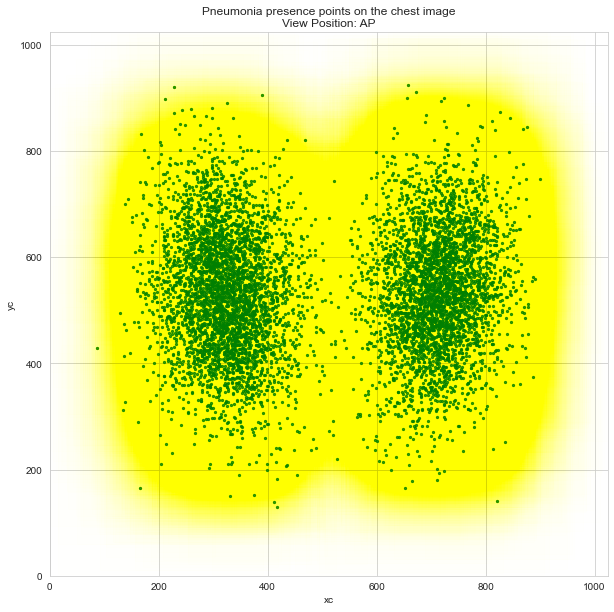

In [49]:
temp = final_train_data
temp['xc'] = temp['x'] + temp['width'] / 2
temp['yc'] = temp['y'] + temp['height'] / 2
rows = (temp['ViewPosition']=='AP')  & (temp['Target']==1)
plot_diagram(temp[ rows ],'green', 'yellow', 'View Position: AP')

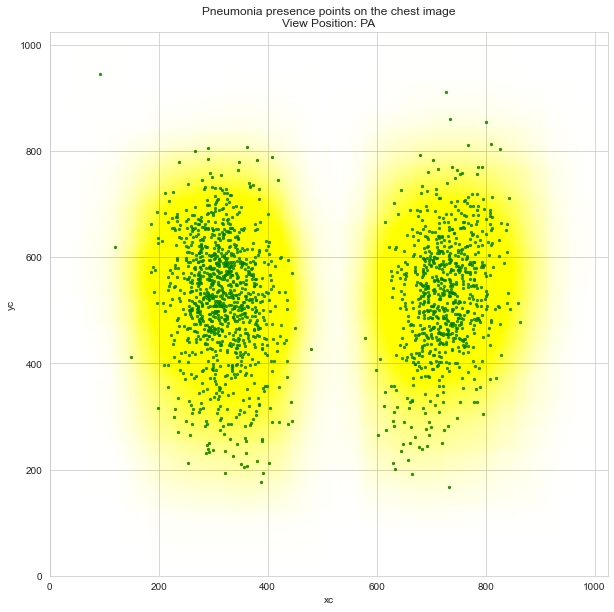

In [50]:
rows = (temp['ViewPosition']=='PA')  & (temp['Target']==1)
plot_diagram(temp[ rows ],'green', 'yellow', 'View Position: PA')

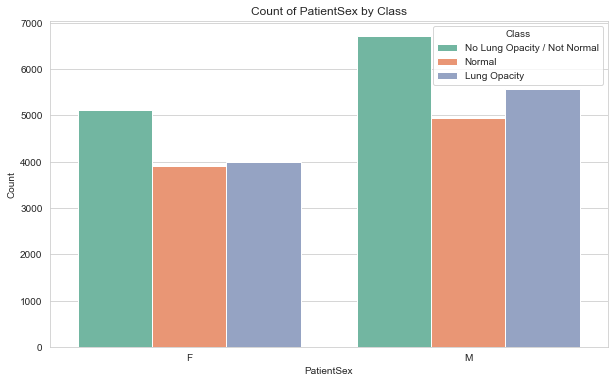

In [51]:
# count plot of PatientSex by class
plt.figure(figsize=(10, 6))
sns.countplot(data=final_train_data, x='PatientSex', hue='class', palette='Set2')
plt.title("Count of PatientSex by Class")
plt.xlabel("PatientSex")
plt.ylabel("Count")
plt.legend(title='Class', loc='upper right')
plt.show()

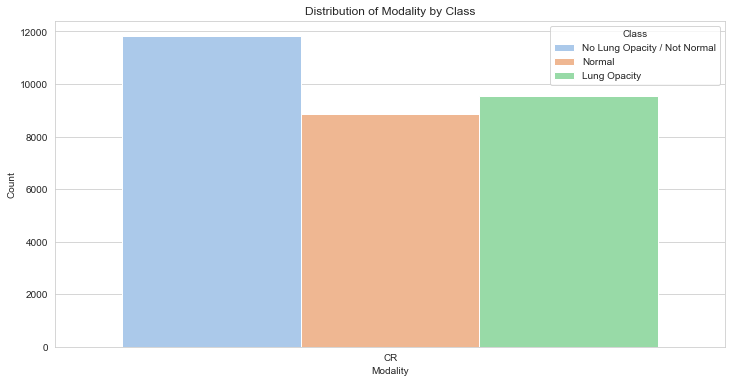

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(data=final_train_data, x='Modality', hue='class', palette='pastel')
plt.title("Distribution of Modality by Class")
plt.xlabel("Modality")
plt.ylabel("Count")
plt.legend(title='Class', loc='upper right')
plt.show()

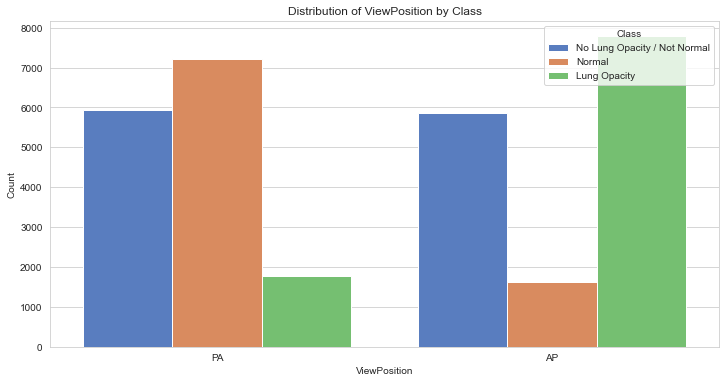

In [53]:
plt.figure(figsize=(12, 6))
sns.countplot(data=final_train_data, x='ViewPosition', hue='class', palette='muted')
plt.title("Distribution of ViewPosition by Class")
plt.xlabel("ViewPosition")
plt.ylabel("Count")
plt.legend(title='Class', loc='upper right')
plt.show()

In [54]:
images_dir = 'stage_2_train_images'

# Function to load and preprocess DICOM images
def load_and_preprocess_image(image_path):
    dcm = pydicom.dcmread(image_path)
    
    # Apply resizing (e.g., resize to 224x224)
    image = transform.resize(dcm.pixel_array, (128, 128), anti_aliasing=True)
    
    # Normalize pixel values to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    return image

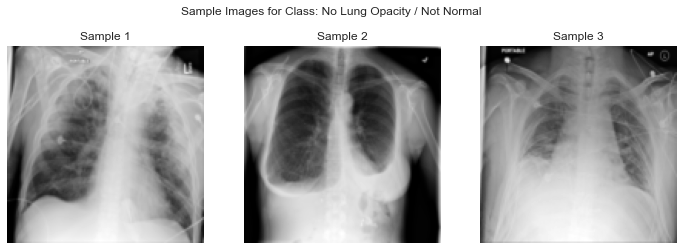

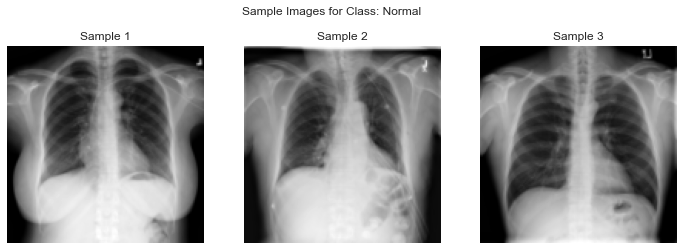

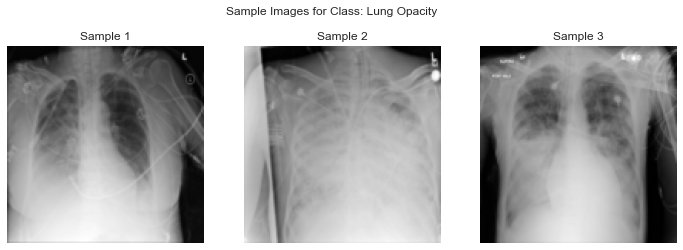

In [55]:
# Visualization of different classes 
classes = final_train_data['class'].unique()

# Visualize sample images from each class
for cls in classes:
    sample_images = final_train_data[final_train_data['class'] == cls]['image_path'].sample(3, random_state=42)
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Sample Images for Class: {cls}')
    
    for i, image_path in enumerate(sample_images):
        plt.subplot(1, 3, i + 1)
        image = load_and_preprocess_image(image_path)
        plt.imshow(image, cmap='gray')
        plt.title(f'Sample {i + 1}')
        plt.axis('off')
    
    plt.show()

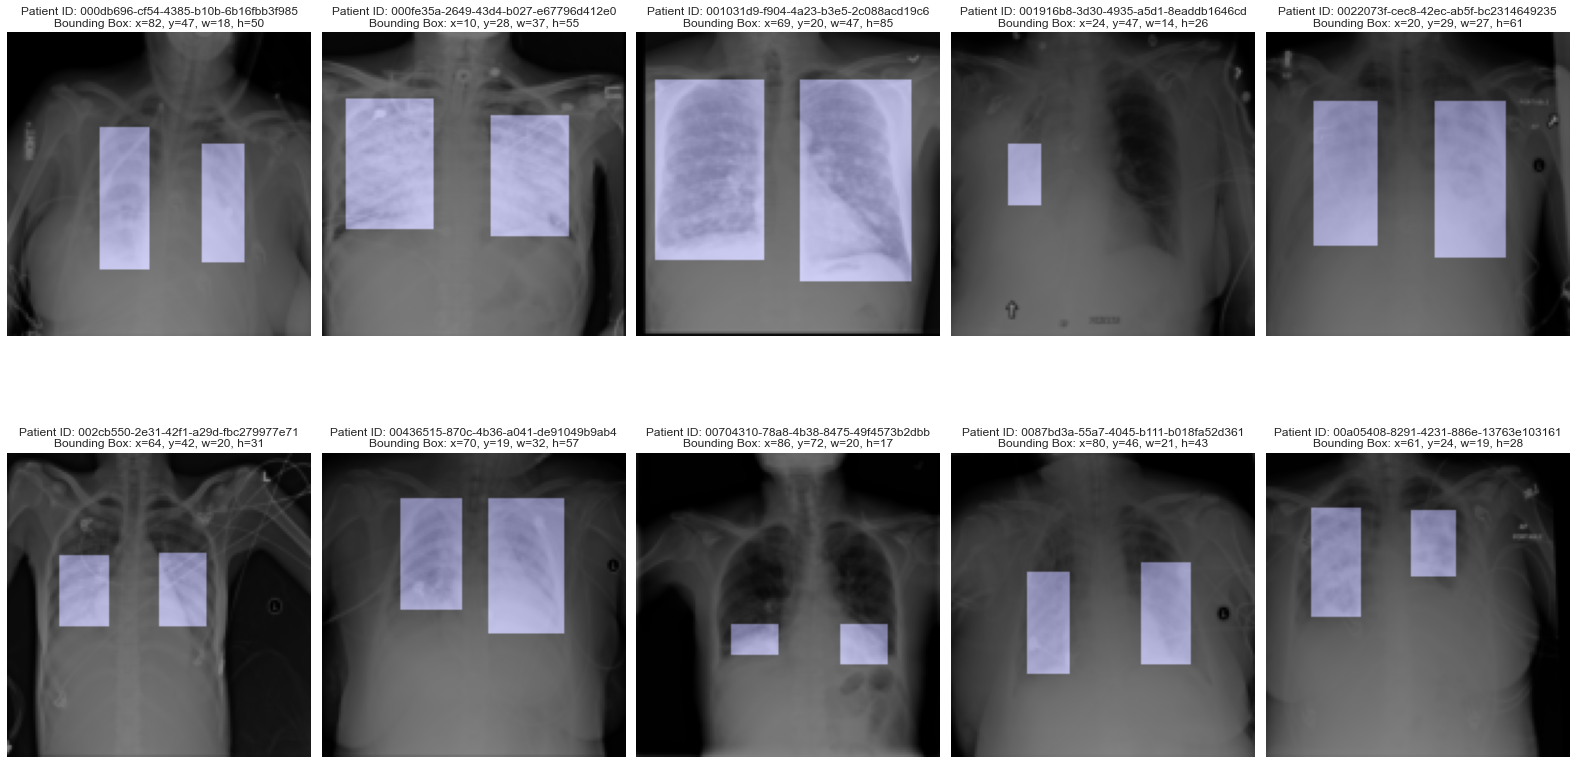

In [56]:
import matplotlib.pyplot as plt
import pydicom
import numpy as np
from skimage import transform

def load_and_preprocess_image(image_path):
    dcm = pydicom.dcmread(image_path)
    image = dcm.pixel_array
    image = transform.resize(image, (128, 128), anti_aliasing=True)
    return image

# Filter the DataFrame to include only rows with bounding boxes
data_with_bboxes = final_train_data.dropna(subset=['x'])

# Group the data by patient ID
grouped_data = data_with_bboxes.groupby('patientId')

# Initialize a counter to print only 10 images
image_counter = 0

# Plot images with bounding boxes for each patient
fig, axes = plt.subplots(2, 5, figsize=(22, 13))

for patient_id, group in grouped_data:
    # Create an empty overlay image with the same dimensions as the original
    overlay_image = np.zeros((128, 128, 3))
    
    for _, row in group.iterrows():
        image_path = row['image_path']
        image = load_and_preprocess_image(image_path)
        
        # Calculate scaling factors
        width_scale = 128 / 1024
        height_scale = 128 / 1014
        x_scaled = int(row['x'] * width_scale)
        y_scaled = int(row['y'] * height_scale)
        width_scaled = int(row['width'] * width_scale)
        height_scaled = int(row['height'] * height_scale)
        
        # Overlay the bounding box using a light blue shaded region
        overlay_image[y_scaled:y_scaled+height_scaled, x_scaled:x_scaled+width_scaled, :] = [0.7, 0.7, 1.0]  # Light blue shading
        
    # Display the original image with overlaid bounding boxes
    row_idx = image_counter // 5
    col_idx = image_counter % 5
    
    # Load and preprocess the original image
    original_image_path = group.iloc[0]['image_path']  # Use the first image as the original
    original_image = load_and_preprocess_image(original_image_path)
    
    # Display the original image
    ax = axes[row_idx, col_idx]
    ax.imshow(original_image, cmap='gray')
    ax.imshow(overlay_image, alpha=0.5)  # Overlay the bounding boxes with transparency
    ax.set_title(f'Patient ID: {row["patientId"]}\nBounding Box: x={x_scaled}, y={y_scaled}, w={width_scaled}, h={height_scaled}')
    ax.axis('off')
    
    image_counter += 1
    if image_counter == 10:
        break  # Print only 10 images

plt.tight_layout()
plt.show()

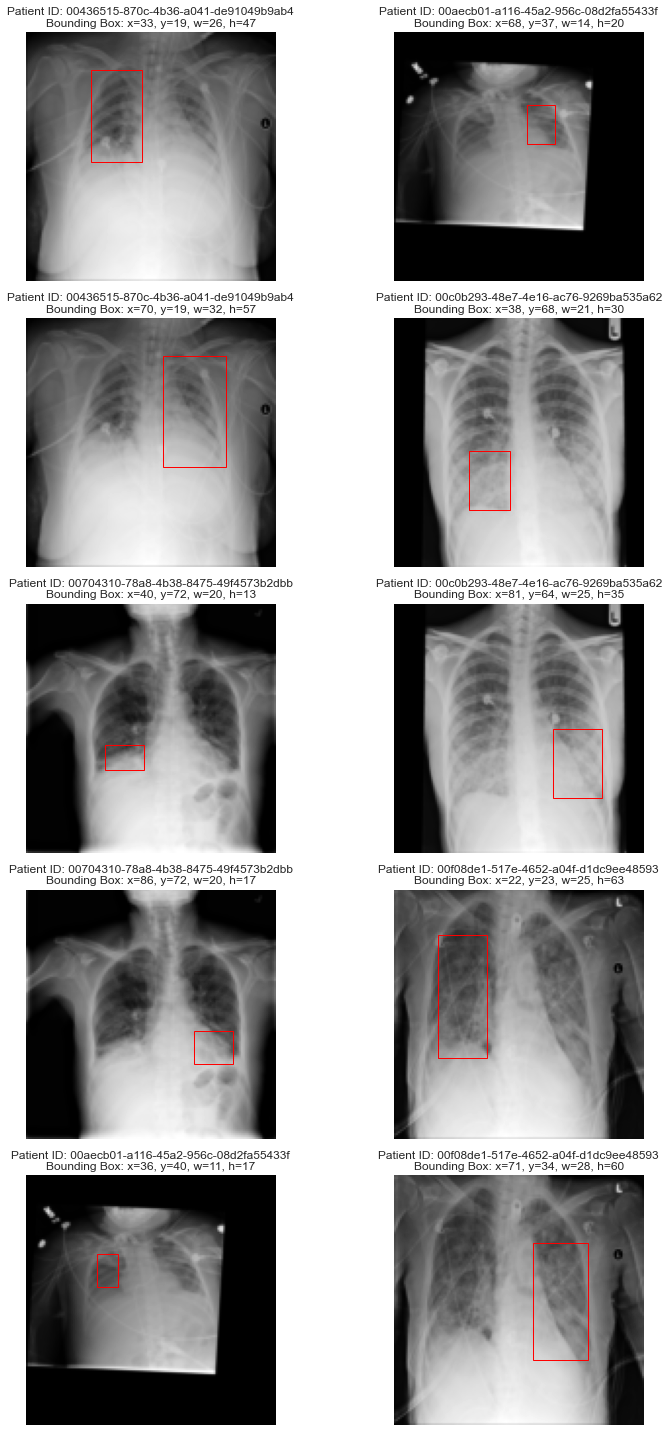

In [57]:
def load_and_preprocess_image(image_path):
    dcm = pydicom.dcmread(image_path)
    image = dcm.pixel_array
    
    image = transform.resize(image, (128, 128), anti_aliasing=True)
    
    return image

# Filter the DataFrame to include only rows with bounding boxes
data_with_bboxes = final_train_data.dropna(subset=['x'])

# Plot the images with bounding boxes
num_images_to_display = min(10, len(data_with_bboxes))
num_cols = 2  # Number of columns (1 for image, 1 for bounding box info)
num_rows = (num_images_to_display + 1) // 2   # Number of rows (adjust as needed)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

for i, (index, row) in enumerate(data_with_bboxes.head(num_images_to_display).iterrows()):
    image_path = row['image_path']
    
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    
    # Calculate scaling factors
    width_scale = 128 / 1024  # New width divided by original width
    height_scale = 128 / 1014  # New height divided by original height
    
    # Scale the bounding box coordinates
    x_scaled = int(row['x'] * width_scale)
    y_scaled = int(row['y'] * height_scale)
    width_scaled = int(row['width'] * width_scale)
    height_scaled = int(row['height'] * height_scale)
    
    # Determine the subplot position
    row_idx = i % num_rows
    col_idx = i // num_rows
    
    # Display image with bounding box
    ax = axes[row_idx, col_idx]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Patient ID: {row["patientId"]}\nBounding Box: x={x_scaled}, y={y_scaled}, w={width_scaled}, h={height_scaled}')
    ax.axis('off')
    ax.add_patch(plt.Rectangle((x_scaled, y_scaled), width_scaled, height_scaled, edgecolor='r', facecolor='none'))

plt.tight_layout()
plt.show()

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
image_paths = final_train_data['image_path'].tolist()
labels = final_train_data['class'].map({'No Lung Opacity / Not Normal': 0, 'Lung Opacity': 1, 'Normal': 2}).tolist()

In [60]:
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [61]:
# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [62]:
# Load and preprocess the images (you may need to loop through the image paths)
train_images = np.array([load_and_preprocess_image(image_path) for image_path in train_images])
test_images = np.array([load_and_preprocess_image(image_path) for image_path in test_images])

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

In [64]:
# Define your CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax') 
])

In [65]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
756/756 [==============================] - 17s 14ms/step - loss: 0.8899 - accuracy: 0.5582 - val_loss: 0.8456 - val_accuracy: 0.6014
Epoch 2/10
756/756 [==============================] - 8s 11ms/step - loss: 0.8167 - accuracy: 0.6111 - val_loss: 0.8161 - val_accuracy: 0.6125
Epoch 3/10
756/756 [==============================] - 8s 10ms/step - loss: 0.7890 - accuracy: 0.6268 - val_loss: 0.7877 - val_accuracy: 0.6264
Epoch 4/10
756/756 [==============================] - 8s 10ms/step - loss: 0.7581 - accuracy: 0.6442 - val_loss: 0.7748 - val_accuracy: 0.6378
Epoch 5/10
756/756 [==============================] - 8s 11ms/step - loss: 0.7244 - accuracy: 0.6650 - val_loss: 0.7866 - val_accuracy: 0.6328
Epoch 6/10
756/756 [==============================] - 8s 10ms/step - loss: 0.6882 - accuracy: 0.6850 - val_loss: 0.7508 - val_accuracy: 0.6512
Epoch 7/10
756/756 [==============================] - 8s 11ms/step - loss: 0.6478 - accuracy: 0.7046 - val_loss: 0.7450 - val_accuracy: 0.657

In [70]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test accuracy and loss
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

189/189 [==============================] - 1s 4ms/step - loss: 0.9035 - accuracy: 0.6609
Test accuracy: 0.6609328389167786
Test loss: 0.9034757614135742


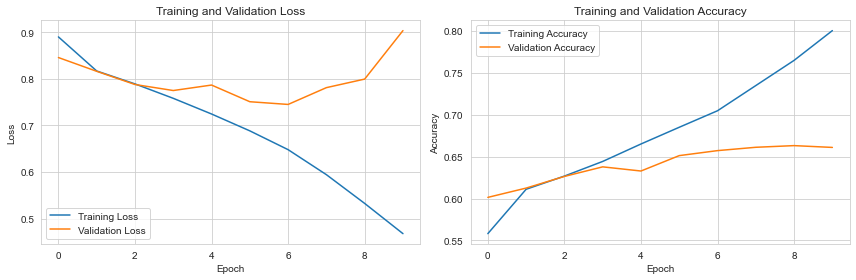

In [71]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

189/189 [==============================] - 1s 3ms/step
Classification Report:
                               precision    recall  f1-score   support

No Lung Opacity / Not Normal       0.66      0.77      0.71      1911
                Lung Opacity       0.62      0.52      0.56      2385
                      Normal       0.71      0.73      0.72      1750

                    accuracy                           0.66      6046
                   macro avg       0.66      0.67      0.67      6046
                weighted avg       0.66      0.66      0.66      6046



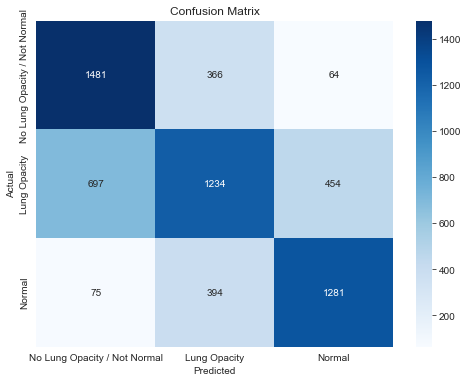

In [74]:
# Generate predictions on the test dataset
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Convert numeric labels back to class names
class_names = ['No Lung Opacity / Not Normal', 'Lung Opacity', 'Normal']
test_labels_names = [class_names[label] for label in test_labels]
test_predictions_names = [class_names[label] for label in test_predictions_classes]

# Calculate the classification report
classification_rep = classification_report(test_labels_names, test_predictions_names, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels_names, test_predictions_names)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 15ms/step


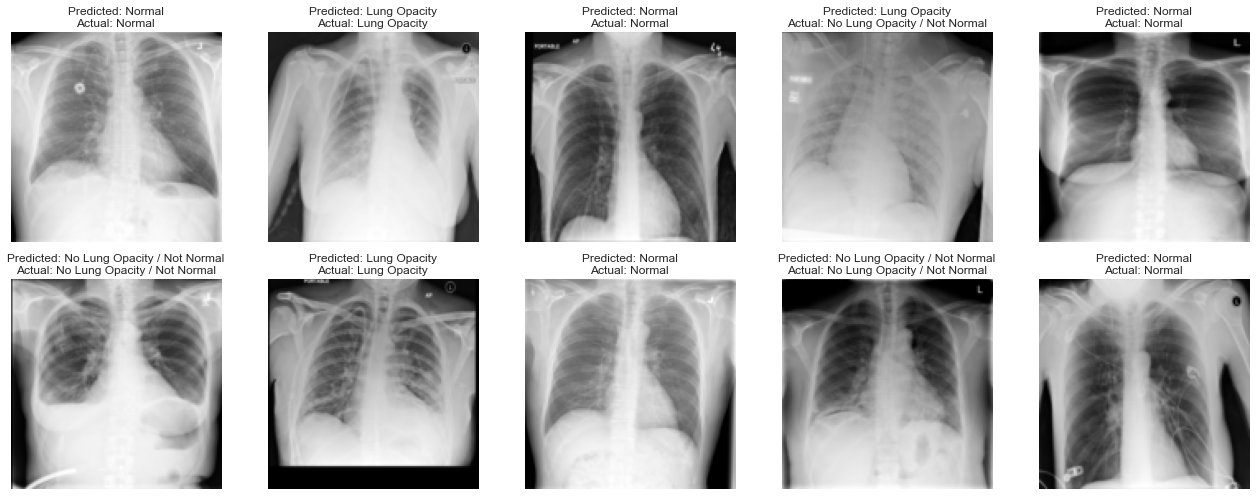

In [75]:
import random

# Randomly select 10 samples from the test dataset
num_samples_to_display = 10
random_indices = random.sample(range(len(test_images)), num_samples_to_display)

# Create a grid layout for displaying images and labels
num_rows = 2
num_cols = 5

plt.figure(figsize=(18, 7))

for i, index in enumerate(random_indices):
    sample_image = test_images[index]
    sample_label = test_labels[index]

    # Reshape the image to match the input shape of your model
    sample_image = sample_image.reshape(1, 128, 128, 1)

    # Make predictions using the model
    predictions = model.predict(sample_image)
    predicted_class = np.argmax(predictions)

    # Map class indices back to class labels
    class_labels = {0: 'No Lung Opacity / Not Normal', 1: 'Lung Opacity', 2: 'Normal'}
    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[sample_label]

    # Create a subplot for each sample
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_image.reshape(128, 128), cmap='gray')
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [76]:
model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  
])

In [77]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [78]:
checkpoint_callback = ModelCheckpoint('best_model_2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [79]:
with tf.device('/GPU:0'):
    history_2 = model_2.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=[checkpoint_callback])

Epoch 1/10
756/756 [==============================] - ETA: 0s - loss: 1.0133 - accuracy: 0.5444
Epoch 1: val_accuracy improved from -inf to 0.56302, saving model to best_model_2.h5
756/756 [==============================] - 18s 19ms/step - loss: 1.0133 - accuracy: 0.5444 - val_loss: 0.8879 - val_accuracy: 0.5630
Epoch 2/10
755/756 [============================>.] - ETA: 0s - loss: 0.8426 - accuracy: 0.5976
Epoch 2: val_accuracy did not improve from 0.56302
756/756 [==============================] - 13s 17ms/step - loss: 0.8426 - accuracy: 0.5978 - val_loss: 1.7490 - val_accuracy: 0.3391
Epoch 3/10
756/756 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.6128
Epoch 3: val_accuracy did not improve from 0.56302
756/756 [==============================] - 13s 17ms/step - loss: 0.8142 - accuracy: 0.6128 - val_loss: 1.1732 - val_accuracy: 0.4343
Epoch 4/10
753/756 [============================>.] - ETA: 0s - loss: 0.7789 - accuracy: 0.6306
Epoch 4: val_accuracy did not 

In [80]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_2.evaluate(train_images, train_labels)
print(f'Training accuracy: {train_accuracy}')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_2.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy}') 

756/756 [==============================] - 4s 5ms/step - loss: 0.8965 - accuracy: 0.6111
Training accuracy: 0.6111409664154053
189/189 [==============================] - 1s 5ms/step - loss: 1.0112 - accuracy: 0.5762
Test accuracy: 0.5762487649917603


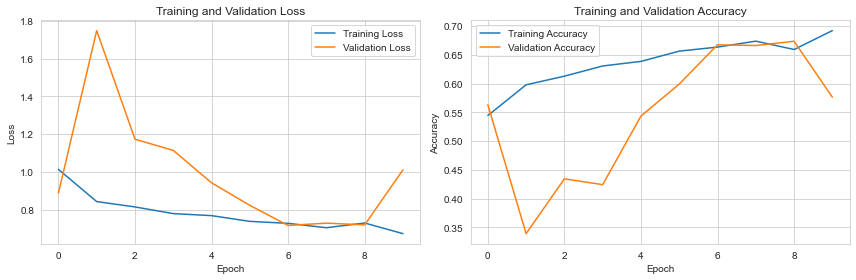

In [81]:
train_loss = history_2.history['loss']
train_accuracy = history_2.history['accuracy']
val_loss = history_2.history['val_loss']
val_accuracy = history_2.history['val_accuracy']


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import classification_report, confusion_matrix

189/189 [==============================] - 1s 4ms/step
Classification Report:
                               precision    recall  f1-score   support

No Lung Opacity / Not Normal       0.75      0.43      0.54      1911
                Lung Opacity       0.54      0.42      0.47      2385
                      Normal       0.54      0.95      0.69      1750

                    accuracy                           0.58      6046
                   macro avg       0.61      0.60      0.57      6046
                weighted avg       0.60      0.58      0.56      6046



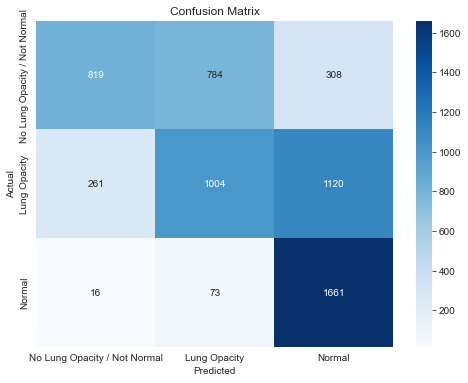

In [83]:
# Generate predictions on the test dataset
test_predictions = model_2.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Convert numeric labels back to class names
class_names = ['No Lung Opacity / Not Normal', 'Lung Opacity', 'Normal']
test_labels_names = [class_names[label] for label in test_labels]
test_predictions_names = [class_names[label] for label in test_predictions_classes]

# Calculate the classification report
classification_rep = classification_report(test_labels_names, test_predictions_names, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels_names, test_predictions_names)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 14ms/step


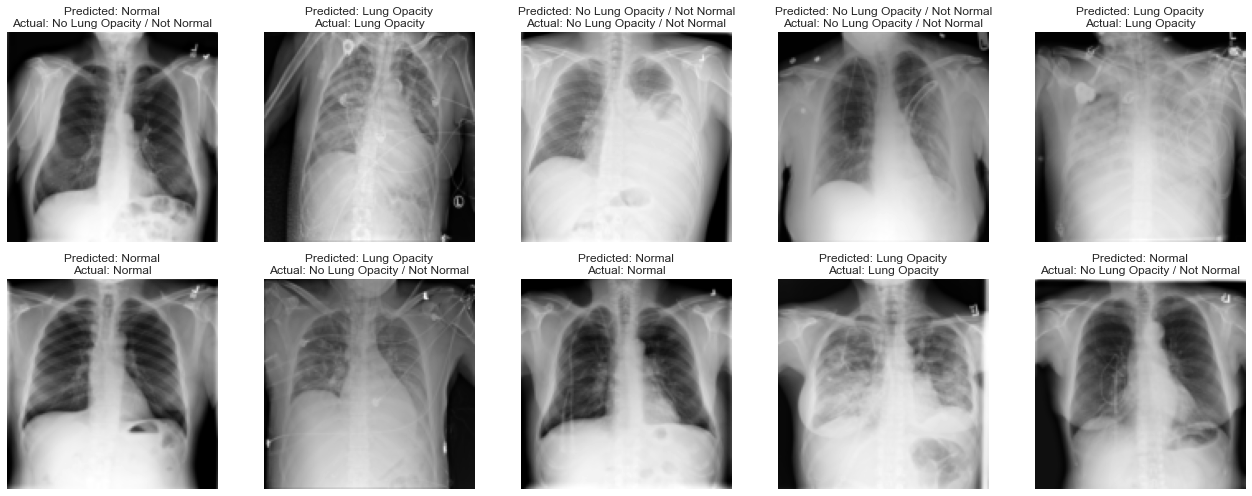

In [84]:
import random

# Randomly select 10 samples from the test dataset
num_samples_to_display = 10
random_indices = random.sample(range(len(test_images)), num_samples_to_display)

# Create a grid layout for displaying images and labels
num_rows = 2
num_cols = 5

plt.figure(figsize=(18, 7))

for i, index in enumerate(random_indices):
    sample_image = test_images[index]
    sample_label = test_labels[index]

    # Reshape the image to match the input shape of your model
    sample_image = sample_image.reshape(1, 128, 128, 1)

    # Make predictions using the model
    predictions = model_2.predict(sample_image)
    predicted_class = np.argmax(predictions)

    # Map class indices back to class labels
    class_labels = {0: 'No Lung Opacity / Not Normal', 1: 'Lung Opacity', 2: 'Normal'}
    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[sample_label]

    # Create a subplot for each sample
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_image.reshape(128, 128), cmap='gray')
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [94]:
class_weights = {
    0: len(train_labels) / (2 * np.sum(train_labels == 0)),
    1: len(train_labels) / (2 * np.sum(train_labels == 1)),
    2: len(train_labels) / (2 * np.sum(train_labels == 2))
}

In [86]:
model3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  
])

In [95]:
checkpoint_callback3 = ModelCheckpoint('best_model_3.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [96]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
with tf.device('/GPU:0'):
    history3 = model3.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), class_weight=class_weights, callbacks=[checkpoint_callback3])

Epoch 1/10
754/756 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.6881
Epoch 1: val_accuracy improved from -inf to 0.64092, saving model to best_model_3.h5
756/756 [==============================] - 15s 18ms/step - loss: 0.9872 - accuracy: 0.6881 - val_loss: 0.7780 - val_accuracy: 0.6409
Epoch 2/10
754/756 [============================>.] - ETA: 0s - loss: 0.9458 - accuracy: 0.7057
Epoch 2: val_accuracy did not improve from 0.64092
756/756 [==============================] - 13s 18ms/step - loss: 0.9459 - accuracy: 0.7056 - val_loss: 0.8240 - val_accuracy: 0.6197
Epoch 3/10
755/756 [============================>.] - ETA: 0s - loss: 0.9015 - accuracy: 0.7207
Epoch 3: val_accuracy improved from 0.64092 to 0.66044, saving model to best_model_3.h5
756/756 [==============================] - 13s 18ms/step - loss: 0.9017 - accuracy: 0.7208 - val_loss: 0.7655 - val_accuracy: 0.6604
Epoch 4/10
756/756 [==============================] - ETA: 0s - loss: 0.8443 - accuracy: 

In [98]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model3.evaluate(test_images, test_labels)

# Print the test accuracy and loss
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

189/189 [==============================] - 1s 5ms/step - loss: 0.9471 - accuracy: 0.7049
Test accuracy: 0.7049288749694824
Test loss: 0.9470892548561096


189/189 [==============================] - 1s 4ms/step
Classification Report:
                               precision    recall  f1-score   support

No Lung Opacity / Not Normal       0.71      0.78      0.74      1911
                Lung Opacity       0.68      0.57      0.62      2385
                      Normal       0.73      0.81      0.76      1750

                    accuracy                           0.70      6046
                   macro avg       0.70      0.72      0.71      6046
                weighted avg       0.70      0.70      0.70      6046



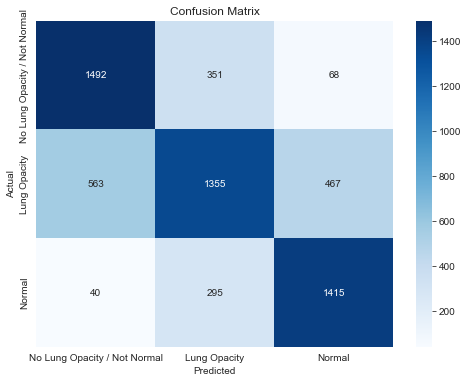

In [99]:
# Generate predictions on the test dataset
test_predictions = model3.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Convert numeric labels back to class names
class_names = ['No Lung Opacity / Not Normal', 'Lung Opacity', 'Normal']
test_labels_names = [class_names[label] for label in test_labels]
test_predictions_names = [class_names[label] for label in test_predictions_classes]

# Calculate the classification report
classification_rep = classification_report(test_labels_names, test_predictions_names, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels_names, test_predictions_names)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

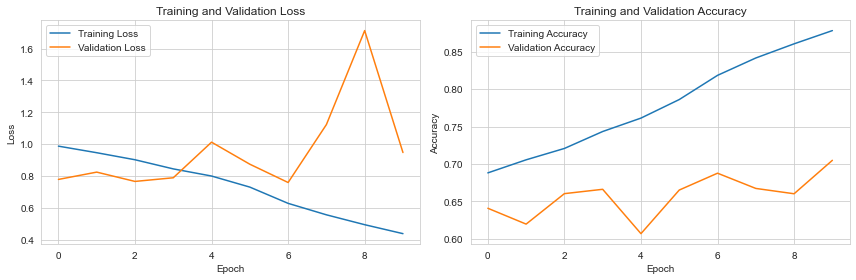

In [100]:
train_loss = history3.history['loss']
train_accuracy = history3.history['accuracy']
val_loss = history3.history['val_loss']
val_accuracy = history3.history['val_accuracy']


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 15ms/step


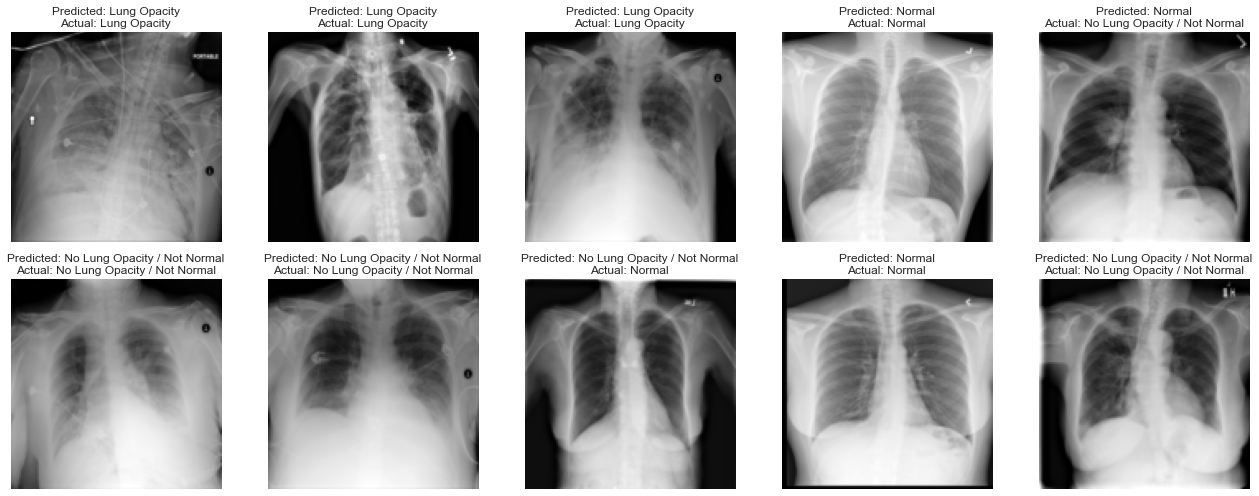

In [101]:
import random

num_samples_to_display = 10
random_indices = random.sample(range(len(test_images)), num_samples_to_display)

num_rows = 2
num_cols = 5

plt.figure(figsize=(18, 7))

for i, index in enumerate(random_indices):
    sample_image = test_images[index]
    sample_label = test_labels[index]

    # Reshape the image to match the input shape of your model
    sample_image = sample_image.reshape(1, 128, 128, 1)
    predictions = model3.predict(sample_image)
    predicted_class = np.argmax(predictions)

    # Map class indices back to class labels
    class_labels = {0: 'No Lung Opacity / Not Normal', 1: 'Lung Opacity', 2: 'Normal'}
    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[sample_label]

    # Create a subplot for each sample
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_image.reshape(128, 128), cmap='gray')
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Model Comparison

In this analysis, we explored three different Convolutional Neural Network (CNN) models for the task of classifying chest X-ray images into three categories: "No Lung Opacity / Not Normal," "Lung Opacity," and "Normal." Below is a comparison of the three models and their respective performance.

### Model 1

**Architecture:**
- Simple CNN model with convolutional and pooling layers.
- No additional regularization techniques.

**Performance:**
- Training Accuracy: 66.09%
- Test Accuracy: 66.09%
- Test Loss: 0.9035

**Classification Report:**
- F1-scores range from 0.56 to 0.72.

### Model 2

**Architecture:**
- More complex CNN model with batch normalization and dropout layers.
- Utilized ModelCheckpoint callback for model saving.

**Performance:**
- Training Accuracy: 61.11%
- Test Accuracy: 57.62%
- Test Loss: 1.0112

**Classification Report:**
- F1-scores range from 0.47 to 0.69.

### Model 3

**Architecture:**
- Similar to Model 2 with additional class weights to address class imbalance.

**Performance:**
- Training Accuracy: 70.49%
- Test Accuracy: 70.49%
- Test Loss: 0.9471

**Classification Report:**
- F1-scores range from 0.62 to 0.76.

### Model Comparison and Insights

- Model 3 outperforms both Model 1 and Model 2 in terms of overall accuracy and F1-scores.
- The introduction of class weights in Model 3 significantly improved its ability to classify each class, addressing class imbalance.
- Model 3's performance is well-balanced across all classes.


## Suggested Improvements
To further enhance model performance:
- Experiment with different architectural variations, including the number of layers and units.
- Explore alternative optimizers and fine-tune hyperparameters.
- Implement data augmentation techniques to diversify the training dataset.
- Evaluate more advanced CNN architectures, such as pre-trained models (e.g., ResNet, Inception, or DenseNet) for transfer learning.
- Consider hyperparameter tuning and cross-validation techniques to optimize model performance.

These models provide a starting point for chest X-ray classification, and further optimizations can lead to even better results.